In [37]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from treeple._lib.sklearn.tree._criterion import Gini
from treeple.tree._oblique_splitter import BestObliqueSplitterTester
from treeple.datasets import make_trunk_classification
import pandas as pd
import math


In [31]:
def plot_proj_existing_data(X, y,
                max_features=10, 
                feature_combinations=1.5,
                plot_fig=True,
                random_state=1):

    criterion = Gini(1, np.array((0, 1)))

    min_samples_leaf = 1
    min_weight_leaf = 0.0
    random_state = np.random.RandomState(random_state)
    n_samples= X.shape[0]
    n_features= X.shape[1]

    #feature_combinations = 3.0
    monotonic_cst = None
    missing_value_feature_mask = None

    # X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_features, n_informative=600, seed=0)
    y = y.reshape(-1,1).astype(np.float64)
    X= X.astype(np.float32)

    sample_weight = np.ones(n_samples)

    splitter = BestObliqueSplitterTester(
        criterion,
        max_features,
        min_samples_leaf,
        min_weight_leaf,
        random_state,
        monotonic_cst,
        feature_combinations,
    )
    splitter.init_test(X, y, sample_weight, missing_value_feature_mask)


    projection_matrix = splitter.sample_projection_matrix_py()
    print("projection matrix shape:", projection_matrix.shape)


    if plot_fig:
        # Visualize the projection matrix
        cmap = ListedColormap(["orange", "white", "green"])

        # Create a heatmap to visualize the indices
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(projection_matrix, cmap=cmap, aspect=n_features / max_features, interpolation="none")

        ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Projection Vector Index")
        ax.set_xticks(np.arange(n_features))
        ax.set_yticks(np.arange(max_features))
        ax.set_yticklabels(np.arange(max_features, dtype=int) + 1)
        ax.set_xticklabels(np.arange(n_features, dtype=int) + 1)

        # Create a mappable object
        sm = ScalarMappable(cmap=cmap)
        sm.set_array([])  # You can set an empty array or values here

        # Create a color bar with labels for each feature set
        colorbar = fig.colorbar(sm, ax=ax, ticks=[0, 0.5, 1], format="%d")
        colorbar.set_label("Projection Weight")
        colorbar.ax.set_yticklabels(["-1", "0", "1"])

        plt.show()
    print("===========================================================================")
    print("Created projection matrix with the following parameters:")
    print(f"n_feature = ", n_features, 
          "\nn_samples = ", n_samples, 
          "\nmax_features = ", max_features, 
          "\nfeature_combinations = ", feature_combinations)
    print("max_features * feature_combinations = ", max_features * feature_combinations)
    print("Number of non-zeros: ",len(projection_matrix.nonzero()[0]))
    return projection_matrix, len(projection_matrix.nonzero()[0])



In [4]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [7]:
## training functions for ydf and treeple

def train_treeple(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a given model and evaluate its accuracy and training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    if isinstance(y_pred[0], np.ndarray):  # Some models return probabilities
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    # print(f"{model_name}: Accuracy = {accuracy:.4f}, Training Time = {train_time:.4f} sec")
    
    return accuracy, train_time, y_pred


def train_ydf(X_train, y_train, X_test, y_test, params_ydf):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    # print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

Initialize parameter settings

In [ ]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 3.0

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure
params_ydf["max_num_nodes"] = 30
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "BINARY"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = 30
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS


In [ ]:
def constant_nNonzeros_simulation(n_tree,                   
                                params_treeple, 
                                params_ydf,
                                target_non_zeros,
                                n_rows,
                                n_columns,
                                n_samples=2000, 
                                n_rep=2, 
                                plot=False):



    accs_ydf = np.zeros((len(n_columns), len(n_rows)))
    times_ydf = np.zeros(accs_ydf.shape)
    accs_treeple = np.zeros(accs_ydf.shape)
    times_treeple = np.zeros(accs_ydf.shape)
    f1_scores = np.zeros(accs_ydf.shape)

    # copy the params to avoid overwriting
    params_treeple1 = params_treeple.copy() 
    params_ydf1 = params_ydf.copy()
    

    for i, n_column in enumerate(n_columns):
        # n_column matches number of features
        n_dim= n_column


        X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # df_train = prepare_dataframe(X_train, y_train)
        # df_test = prepare_dataframe(X_test, y_test)


        for j, n_row in enumerate(n_rows):
            # n_rows matches number of projections            
            feature_combination = target_non_zeros / n_row
            params_treeple1["max_features"] = n_row
            params_treeple1["feature_combinations"] = feature_combination
            
            params_ydf1["sparse_oblique_max_num_projections"] = int(n_row)
            params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
            params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_column, n_row) + 1.0
            
            # see if matches the target non-zeros
            _, treeple_n_nonzeros = plot_proj_existing_data(X, y,
                max_features=n_row, 
                feature_combinations=feature_combination,
                plot_fig=False,
                random_state=1)

            print("-----------------------------------------")        
            print(f"Constants: n_dim: {n_dim} | n_tree: {n_tree} | n_samples: {n_samples} | target_non_zeros: {target_non_zeros} | n_rep: {n_rep}")
            print(f"Projection matrix: n_row: {n_row} | n_column: {n_column} | treeple_non_zeros: {treeple_n_nonzeros}")
            print(f"Feature combinations: {feature_combination} | max_features: {n_row}")

            # check average number of non-zeros per vector
            print("-----------------------------------------")

            
            acc_temp_ydf=0
            time_temp_ydf=0

            acc_temp_treeple=0
            time_temp_treeple=0

            f1_temp=0

            for _ in range(n_rep):
                # --- Train YDF ---
                acc_ydf, time_ydf, pred_ydf = train_ydf(X_train, y_train, X_test, y_test, params_ydf1)
                acc_temp_ydf+=acc_ydf
                time_temp_ydf+=time_ydf
            
                # --- Train Treeple ---
                treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
                acc_treeple, time_treeple, pred_treeple = train_treeple(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
                acc_temp_treeple+=acc_treeple
                time_temp_treeple+=time_treeple

                # Calculate F1 score for two predictions
                f1_compare = f1_score(pred_ydf, pred_treeple)
                f1_temp+=f1_compare

            accs_ydf[i,j] = acc_temp_ydf/n_rep
            times_ydf[i,j] = time_temp_ydf/n_rep

            accs_treeple[i,j] = acc_temp_treeple/n_rep
            times_treeple[i,j] = time_temp_treeple/n_rep

            f1_scores[i,j] = f1_temp/n_rep

    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

Initialize n_rows and n_columns

In [35]:
n_rows = np.ones(5)
n_rows[0] = 32
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

array([ 32,  64, 128, 256, 512])

In [42]:
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = constant_nNonzeros_simulation(
    n_tree=N_ESTIMATORS, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=1024,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=2,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (32, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  32 
feature_combinations =  32.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 32 | n_column: 32 | treeple_non_zeros: 1024
Feature combinations: 32.0 | max_features: 32
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 32. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.628623
Train model on 1600 examples
Model trained in 0:00:00.580485
projection matrix shape: (64, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 64 | n_column: 32 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:00.904895
Train model on 1600 examples
Model trained in 0:00:00.894408
projection matrix shape: (128, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  128 
feature_combinations =  8.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
---------------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.629816
Train model on 1600 examples
Model trained in 0:00:00.612389
projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 64 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:00.969202
Train model on 1600 examples
Model trained in 0:00:00.995372
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  8.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
---------------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.709489
Train model on 1600 examples
Model trained in 0:00:00.692633
projection matrix shape: (64, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 128 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 64 | n_column: 128 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.054059
Train model on 1600 examples
Model trained in 0:00:00.997997
projection matrix shape: (128, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  128 
feature_combinations =  8.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
---------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.791133
Train model on 1600 examples
Model trained in 0:00:00.768878
projection matrix shape: (64, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 256 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 64 | n_column: 256 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.179979
Train model on 1600 examples
Model trained in 0:00:01.119432
projection matrix shape: (128, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  128 
feature_combinations =  8.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
---------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.860532
Train model on 1600 examples
Model trained in 0:00:00.882724
projection matrix shape: (64, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 512 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 2
Projection matrix: n_row: 64 | n_column: 512 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.333551
Train model on 1600 examples
Model trained in 0:00:01.349076
projection matrix shape: (128, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  128 
feature_combinations =  8.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
---------------------------------

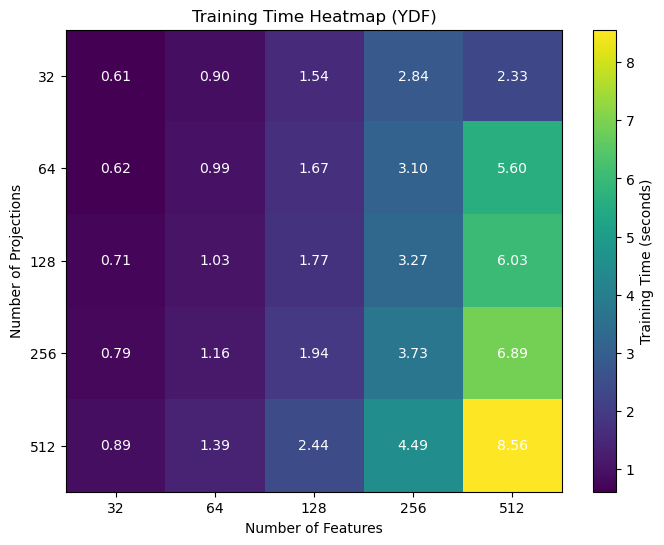

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heatmap
cax = ax.imshow(times_ydf, cmap='viridis', aspect='auto')

# Add color bar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Training Time (seconds)')

# Set axis labels and ticks
ax.set_xticks(np.arange(len(n_columns)))
ax.set_yticks(np.arange(len(n_rows)))
ax.set_xticklabels(n_columns)
ax.set_yticklabels(n_rows)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Projections')
ax.set_title('Training Time Heatmap (YDF)')

# Annotate each block with the training time value
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        ax.text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color='white')

plt.show()

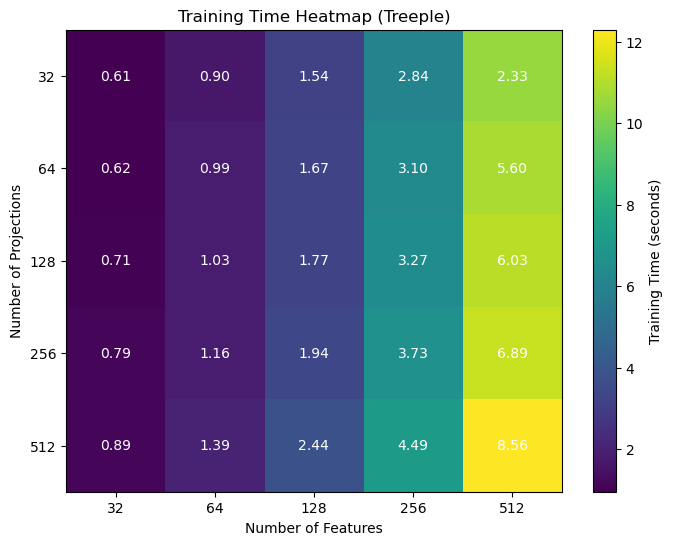

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heatmap
cax = ax.imshow(times_treeple, cmap='viridis', aspect='auto')

# Add color bar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Training Time (seconds)')

# Set axis labels and ticks
ax.set_xticks(np.arange(len(n_columns)))
ax.set_yticks(np.arange(len(n_rows)))
ax.set_xticklabels(n_columns)
ax.set_yticklabels(n_rows)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Projections')
ax.set_title('Training Time Heatmap (Treeple)')

# Annotate each block with the training time value
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        ax.text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color='white')

plt.show()

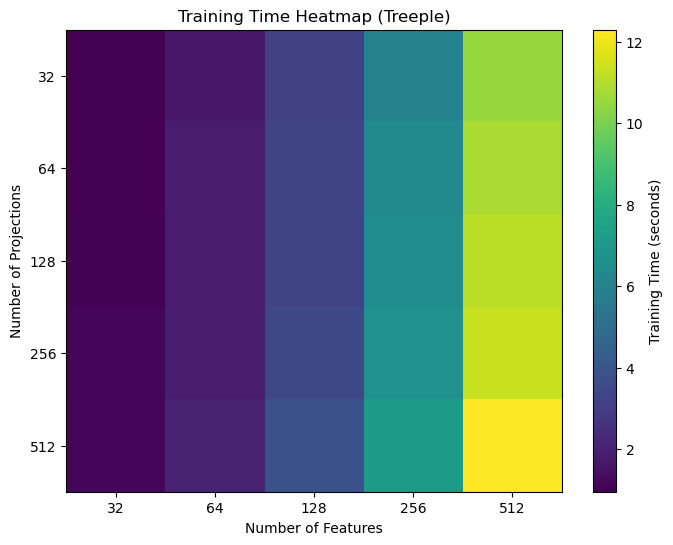

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heatmap
cax = ax.imshow(times_treeple, cmap='viridis', aspect='auto')

# Add color bar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Training Time (seconds)')

# Set axis labels and ticks
ax.set_xticks(np.arange(len(n_columns)))
ax.set_yticks(np.arange(len(n_rows)))
ax.set_xticklabels(n_columns)
ax.set_yticklabels(n_rows)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Projections')
ax.set_title('Training Time Heatmap (Treeple)')

plt.show()